# Mosaic Analysis
See this on [Github](), [NbViewer]()<br>
By Leon Yin 2019-04-05<br>

In this notebook we will used convolutional features and image metadata to generate visual mosaics over time.

To do so, we must transform our dimension-rich data into 2-dimensions. There are a trove of techniques to do dimensionality reduction, but in this case we'll be using an algorithm called UMap. UMap is unique because it allows us to persist the model and reuse it. This allows us to project our data into the same 2-dimensional latent space with new data.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import sys
import gc
import random
import datetime
import json

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import imageio
from PIL import Image, ImageFont, ImageDraw 
from sklearn.externals import joblib
import umap
import numba
sys.path.append('/home/chino/code/open-source/rasterfairy/')
from rasterfairy import transformPointCloud2D

import config
# from utils import resize_image

ImportError: attempted relative import with no known parent package

In [3]:
from rasterfairy import transformPointCloud2D

SyntaxError: invalid syntax (rfoptimizer.py, line 98)

In [14]:
numba.__version__, umap.__version__

('0.43.1', '0.3.8')

## Dimensionality Reduction
Fitting UMAP.

In [15]:
# UMAP Params
n_neighbors = 25
metric = 'euclidean'
min_dist = 0.5
training_set_size = 10000
overwrite_model = False # set to True to re-train the model.

# Model files
file_encoder = (f'{ config.working_dir }/encoder_{ str(min_dist).replace(".", "-") }_'
                f'dist_{ metric }_sample_{ training_set_size }.pkl')
file_training_set = f'{ config.working_dir }umap_training_data_{ training_set_size }.csv'

In [16]:
if not os.path.exists(file_encoder) or overwrite_model:
    # Create the training set (note: UMAP can be either supervised or unsupervised.)
    if not os.path.exists(file_training_set):
        df_conv = pd.read_csv(config.logits_file, index_col=0, 
                              compression='gzip')
        training_set = df_conv[cols_conv_feats].sample(training_set_size, 
                                                       random_state=303)
    else:
        training_set = pd.read_csv(file_training_set, index_col=0)
    
    # fit the model scikit-learn style
    encoder = umap.UMAP(n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        metric=metric,
                        random_state=303,
                        verbose=1).fit(training_set.values)

    # save the model for later! Save the training data, too.
    joblib.dump(encoder, file_encoder)                             
    training_set.to_csv(file_training_set)

NameError: name 'cols_conv_feats' is not defined

This creates a scatterplot, we use Mario Klingmann's RasterFairy software to convert this pointcloud into neat rows and columns.

## Dimensionality Reduction and Vidualization
Here we will reduce the convolutional features from 2048-dimensions to 2-dimensions so they are easy to visualize. We'll need to join in each image's metadata (including the path of each file) to the convolutonal features creating `df_merge`. We'll take a sample of that data and visualize it as a scatterplot of images.

In [6]:
# Join the image metadata with convolutional features
if not os.path.exists(config.full_metadata_file):
    # Read image metadata
    df_media = pd.read_json(config.image_lookup_file, lines=True, 
                            orient='records', compression='gzip')
    df_media = df_media[~df_media['d_hash'].isin(skip_hash)]
    
    # Merge the datasets
    merge_cols = [c for c in df_media.columns if c != 'f_img']
    df_merged = (pd.merge(left=df_media[merge_cols],
                          right=df_conv.reset_index(), 
                          how='left',
                          left_on='d_hash',
                          right_on='index').sort_values(by='created_at',  
                                                        ascending=True))
    df_merged = df_merged[df_merged.created_at >= cutoff_date]
    df_merged.to_csv(config.full_metadata_file, compression='gzip')
else:
    df_merged = pd.read_csv(config.full_metadata_file, index_col=0, compression='gzip')
    df_merged.created_at = pd.to_datetime(df_merged.created_at, format='%Y-%m-%d %H:%M:%S')

/home/ly501/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,46,54,55,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df_merged.head(2)

approved_at_utc  archived        author  author_cakeday  \
105801              NaN       NaN  Joshenkstone             NaN   
105800              NaN       NaN         -jtw-             NaN   

        author_created_utc author_flair_background_color  \
105801                 NaN                           NaN   
105800                 NaN                           NaN   

       author_flair_css_class author_flair_richtext author_flair_template_id  \
105801                    NaN                    []                      NaN   
105800                    NaN                    []                      NaN   

       author_flair_text  ... conv_2039 conv_2040 conv_2041  conv_2042  \
105801               NaN  ...  0.013057  0.032384  0.023884   0.359307   
105800               NaN  ...  0.250077  0.972220  0.394084   0.521223   

        conv_2043  conv_2044  conv_2045  conv_2046  conv_2047  \
105801   0.028649   0.348962   0.037158   0.000000   0.018470   
105800   0.136749   0.148514   0.147933   0.025603   0.204758   

                                                    f_img  
105801  /beegfs/work/smapp/reddit_/media/n-/yj/n-YJleo...  
105800  /beegfs/work/smapp/reddit_/media/dy/tc/DyTcLfB...  

[2 rows x 2142 columns]

In [8]:
# variables for the mosaic
tile_width, tile_height = 36, 28 #pixel dimenstions per image
nx, ny = 48, 30                  # number of images in the x and y axis
sample_size = nx * ny
aspect_ratio = float(tile_width) / tile_height

In [9]:
# load the model
encoder = joblib.load(file_encoder)

In [10]:
# sample the dataset
df_sample = df_merged.sample(sample_size, random_state=303)
min_date = df_sample.created_at.min()
max_date = df_sample.created_at.max()
images = df_sample.f_img
embeddings = encoder.transform(df_sample[config.cols_conv_feats].values)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [11]:
def scatterplot_images(embeddings, images,
                width = 1200, height = 900, 
                max_dim = 40):
    '''
    Plots images in a scatterplot where coordinates are from
    embeddings.
    '''
    tx, ty = embeddings[:,0], embeddings[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

    full_image = Image.new('RGB', 
                           size=(width, height), 
                           color=(55, 61, 71))

    for f_img, x, y in tqdm(zip(images, tx, ty)):
        # read and resize image
        tile = Image.open(f_img)
        rs = max(1, tile.width / max_dim, tile.height / max_dim)
        tile_width_ = int(tile.width / rs)
        tile_height_ = int(tile.height / rs)
        aspect_ratio_ = float(tile_width) / tile_height 
        tile = resize_image(tile, tile_width, tile_height, aspect_ratio)

        # add the image to the graph               
        x_coord = int((width - max_dim) * x)
        y_coord = int((height - max_dim) * y)
        img_coords = (x_coord, y_coord)
        full_image.paste(tile, box=img_coords, mask=tile.convert('RGBA'))

    return full_image

1440it [00:26, 54.77it/s]


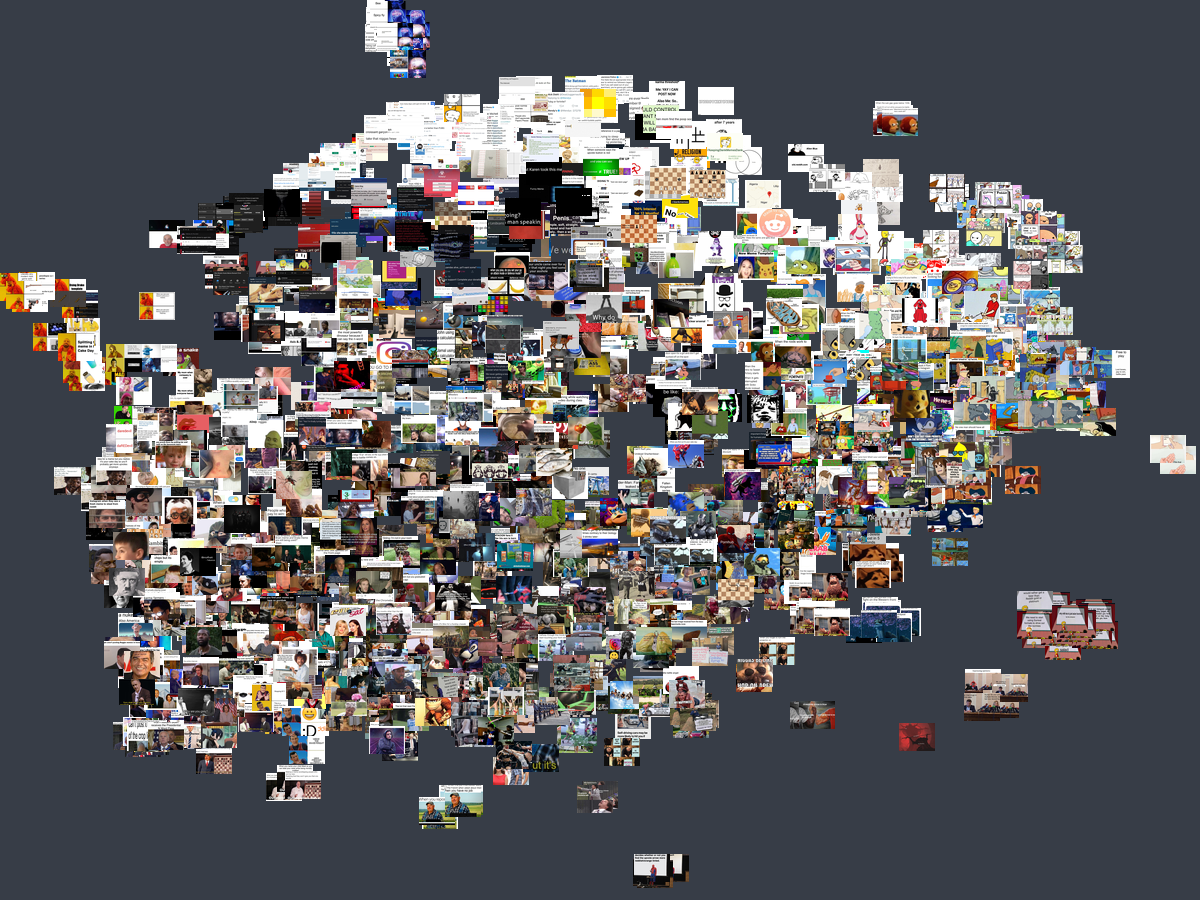

In [12]:
scatterplot_images(embeddings, images)

## Mosaics
We can further alter these dimensions by reducing the scatterplot into a grid of images using Mario Klingmann's `rasterfairy` Python package. We'll create two utility functions to crop and center each image (`preprocess_image_for_mosaics`), and one which converts the scatterplot of 2-dimentional image creatures into a nice gridded mosaic (`generate_mosaic`).

In [13]:
def generate_mosaic(embeddings, images, mosaic_width, mosaic_height,
                    tile_width=72, tile_height=56, title= "Doppler Mosaic",
                    title_rbg=(229, 229, 229), save_as_file=False, 
                    return_image=True, verbose=False):
    '''
    Transforms 2-dimensional embeddings to a grid. 
    Plots the images for each embedding in the corresponding grid (mosaic).
    Includes arguments for the dimensions of each tile and the the mosaic.
    '''
    # assign to grid
    grid_assignment = transformPointCloud2D(embeddings, 
                                            target=(mosaic_width, 
                                                    mosaic_height))
    full_width = tile_width * mosaic_width
    full_height = tile_height * (mosaic_height + 1)
    aspect_ratio = float(tile_width) / tile_height
    
    # create an empty image for the mosaic
    mosaic = Image.new('RGB', (full_width, full_height))
    
    # iterate through each image and where it is possed to live.
    if verbose:
        iterator = tqdm(zip(images, grid_assignment[0]))
    else:
        iterator = zip(images, grid_assignment[0])
    for f_img, (idx_x, idx_y) in iterator:
        # Find exactly where the image will be
        x, y = tile_width * idx_x, tile_height * idx_y
        
        # read the image, center crop the image and add it to the mosaic
        try:
            img = Image.open(f_img).convert('RGBA')
            tile = resize_image(img, tile_width, tile_height, aspect_ratio)
            mosaic.paste(tile, (int(x), int(y)))
        except Exception as e:
            print(f"Failed to add image {f_img} see error:\n{e}")    
    # write an annotation
    fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', tile_height - 3)
    draw = ImageDraw.Draw(mosaic)
    draw.text((4, tile_height * (mosaic_height)), 
               title, title_rbg, font=fnt)
    
    if save_as_file and not os.path.exists(save_as_file):
        try:
            mosaic.save(save_as_file)
        except Exception as e:
            print(f'Saving the mosaic to {save_as_file} failed, see error:\n{e}')
    if return_image:
        return mosaic

1440it [00:24, 59.88it/s]


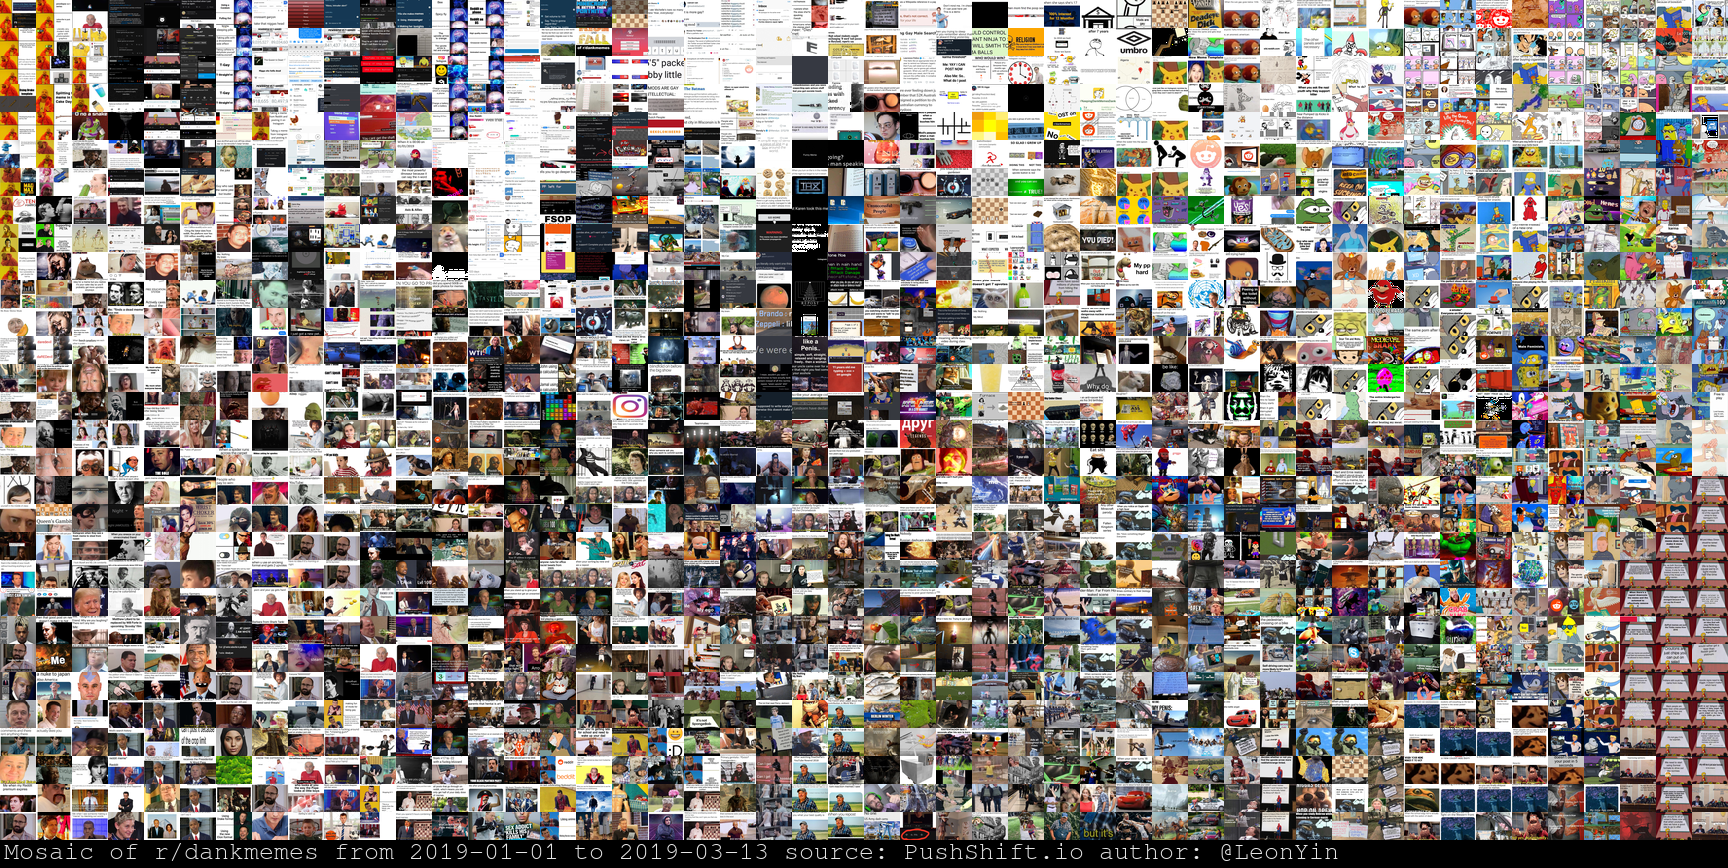

In [14]:
generate_mosaic(embeddings, images, 
                mosaic_width=nx, mosaic_height=ny,
                tile_width=tile_width, tile_height=tile_height,
                save_as_file=False, verbose=True, return_image=True,
                title=f"Mosaic of r/{config.subreddit} "
                       f"from {min_date.strftime('%Y-%m-%d')} "
                       f"to {max_date.strftime('%Y-%m-%d')} "
                        "source: PushShift.io author: @LeonYin")

## Generating and Animation
We can create animations with mosaics by sorting our initial dataset by time and traversing through the dataset by `offset` images. We'll use the `create_mosaic` function for `n_steps` mosaics. We'll keep the filename for each mosaic and use `ImageIO` to create an mp4 file.

In [ ]:
offset = 75
n_steps = 1000
mosaic_files = []
emb_cache = pd.DataFrame(columns=list(df_merged.columns) + ['emb_x', 'emb_y'])
try:
    for i in tqdm(range(n_steps)):
        # where will the image live?
        file_mosaic = os.path.join(config.mosaic_dir, 
                                   os.path.basename(file_encoder.replace('.pkl', '') 
                                   + f'__mosaic__offset_{offset}_sample_{sample_size}_step_{i}.png'))
        if not os.path.exists(file_mosaic):
            # Load encoder
            encoder = joblib.load(file_encoder)
            encoder.verbose = 0

            # Sample the dataset for images to plot
            df_sample = df_merged[i * offset : sample_size + (i * offset)]            
            min_date = df_sample.created_at.min()
            max_date = df_sample.created_at.max()
            
            # drop old embeddings and check cache file for what needs to be transformed.
            emb_cache = emb_cache[emb_cache.index.isin(df_sample.index)]
            to_collect = df_sample[~df_sample.d_hash.isin(emb_cache.d_hash)]
            
            # cache to save compute time 
            new_emb = encoder.transform(to_collect[config.cols_conv_feats].values)
            to_collect = to_collect.assign(emb_x=new_emb[:, 0])
            to_collect = to_collect.assign(emb_y=new_emb[:, 1])
            emb_cache = emb_cache.append(to_collect, sort=False)
            
            del df_sample
            del to_collect
            del new_emb
            
            # this is what we're plotting!
            images = emb_cache.f_img.values
            embeddings = emb_cache[['emb_x', 'emb_y']].values
            
            # create and save the mosaic
            generate_mosaic(embeddings, images, 
                            mosaic_width=nx, mosaic_height=ny,
                            tile_width=tile_width, tile_height=tile_height,
                            save_as_file=file_mosaic, return_image=False,
                            title=f"Mosaic of r/{config.subreddit} "
                                  f"from {min_date.strftime('%Y-%m-%d')} "
                                  f"to {max_date.strftime('%Y-%m-%d')} "
                                  f"via PushShift.io @LeonYin {i}")
            del embeddings
        gc.collect()        
        mosaic_files.append(file_mosaic)
        
except KeyboardInterrupt:
    print("Cancelled early")



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<01:53,  8.81it/s]

  0%|          | 3/1000 [00:00<01:47,  9.24it/s]

  0%|          | 5/1000 [00:00<01:43,  9.59it/s]

  1%|          | 7/1000 [00:00<01:40,  9.90it/s]

  1%|          | 9/1000 [00:00<01:38, 10.11it/s]

  1%|          | 11/1000 [00:01<01:36, 10.24it/s]

  1%|          | 12/1000 [00:01<01:39,  9.91it/s]

  1%|▏         | 14/1000 [00:01<01:37, 10.10it/s]

  2%|▏         | 16/1000 [00:01<01:35, 10.26it/s]

  2%|▏         | 18/1000 [00:01<01:34, 10.38it/s]

  2%|▏         | 20/1000 [00:01<01:33, 10.43it/s]

  2%|▏         | 22/1000 [00:02<01:33, 10.41it/s]

  2%|▏         | 24/1000 [00:02<01:33, 10.43it/s]

  3%|▎         | 26/1000 [00:02<01:32, 10.50it/s]

  3%|▎         | 28/1000 [00:02<01:32, 10.55it/s]

  3%|▎         | 30/1000 [00:02<01:32, 10.54it/s]

  3%|▎         | 32/1000 [00:03<01:32, 10.51it/s]

  3%|▎         | 34/1000 [00:03<01:32, 10.43it/s]

  4%|▎         | 36/1000 [00:03<01:31, 10.5

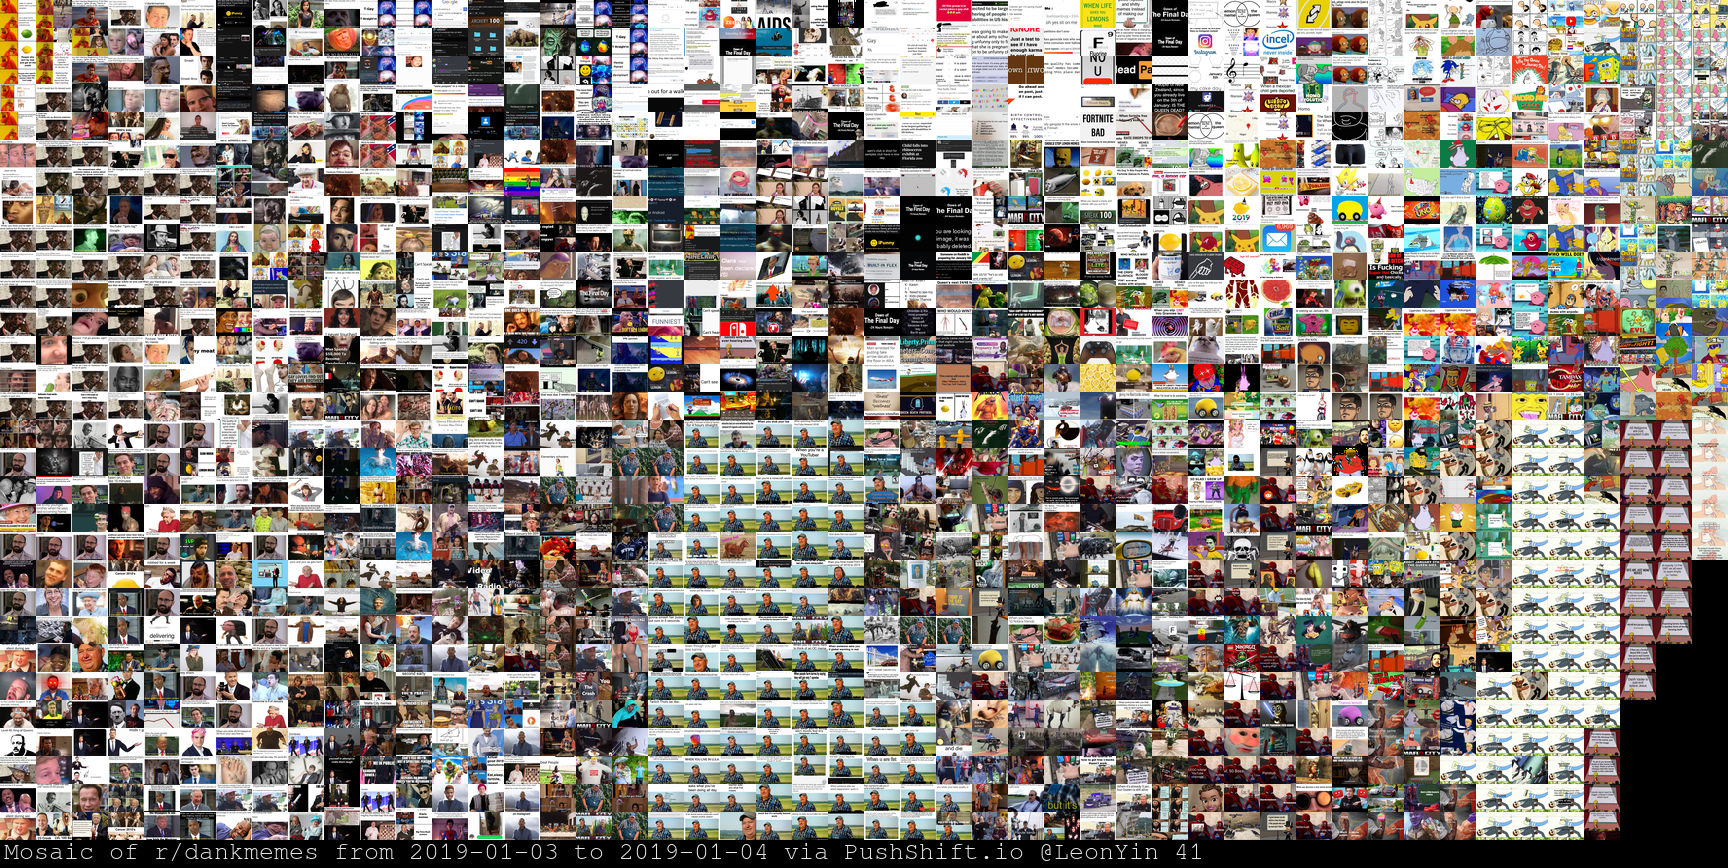

In [17]:
Image.open(mosaic_files[-1])

In [18]:
def make_mp4(files, dest, fps=30):
    '''
    Saves a png for each congress into the figs subdirectory.
    Uses ImageIO to combine images into a gif.
    Deletes all png files in directory.
    '''
    images = []
    writer = imageio.get_writer(dest, fps=fps)
    for f_img in files:
        img = Image.open(f_img)
        # resize the image to a managable size.
        img_width, img_height = img.size
        half_sized = (int(img_width / 1.2), int(img_height / 1.2))
        img = img.resize(half_sized)
        writer.append_data(np.array(img))
    writer.close()

In [19]:
# imageio.plugins.ffmpeg.download()
make_mp4(mosaic_files, config.file_animation, fps=4)

## Vidya
Behold the Doppler Mosaic!
<video controls src="output/doppler_mosaic.mp4" width=720 />